# Movie Recommendation System

## Libraries and Functions

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from surprise import SVD
from surprise import Reader
from surprise import Dataset
import matplotlib.pyplot as plt
from collections import OrderedDict
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

## Dataset

The dataset used in this project was the [MovieLens](http://grouplens.org/datasets/movielens/). Outsourced by GroupLens Minnesota University Research Team. The dataset has several versions, this project used the 100K version.

The dataset is made up for *100.000 ratings* for *1.682 movies* created by *943 users* in a system where *0* corresponded to the lowest rating and *5* to the highest one.

You can find further information in the dataset's [Readme](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).

## Exploration

### Ratings (u.data)
Each line corresponds to the movie rating provided by each user. The ratings are from 0 to 5 stars, being 5 the highest rating, with steps of 0.5 stars. 

The timestamps are expressed in seconds since midnight 01/1970 (UTC).

The format is:

`user id | item id | rating | timestamp`

In [2]:
ratings = pd.read_csv('./dataset/ml-100k/u.data', delimiter='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings.dropna(inplace = True)
ratings.shape

(100000, 4)

In [3]:
ratings.head(2)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742


In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.8 MB


### Users (u.user)
Each line corresponds to an user, demographic information was included. 

The format is:

`user id | age | gender | occupation | zip code`

In [6]:
users = pd.read_csv('./dataset/ml-100k/u.user', delimiter='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
users.dropna(inplace = True)
users.shape

(943, 5)

In [7]:
users.head(2)

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   gender      943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 44.2+ KB


### Movies (u.item)
Each line corresponds to a movie. Errors in names can be found.

The format is: 

`movie id | movie title | release date | video release date | IMDB URL | genres`

The columns with the genres are binaries, telling either the movie can be classified or not in a genre. The genres are listed below:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* unknown

In [9]:
genres = [
    'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', "Film-Noir", 'Horror', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'unknown'
    ]

All the column names are listed below.

In [10]:
col_names = ['movie_id','movie_title','video_release_date','release_year','IMDB_URL'] + genres

Loads the dataset

In [11]:
movies = pd.read_csv('./dataset/ml-100k/u.item', sep = '|', encoding = "ISO-8859-1", names = col_names, parse_dates = ['video_release_date'])
movies.head(2)

,movie_id,movie_title,video_release_date,release_year,IMDB_URL,Action,Adventure,Animation,Children's,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,unknown
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


The unnecessary columns are dropped below.

In [12]:
movies.dropna(axis = 0,subset=['video_release_date'], inplace = True)
movies['release_year'] = movies['video_release_date'].dt.year
movies.shape

(1681, 24)

In [13]:
movies.head(2)

,movie_id,movie_title,video_release_date,release_year,IMDB_URL,Action,Adventure,Animation,Children's,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,unknown
0,1,Toy Story (1995),1995-01-01,1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01,1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


## Exploration

### Ratings

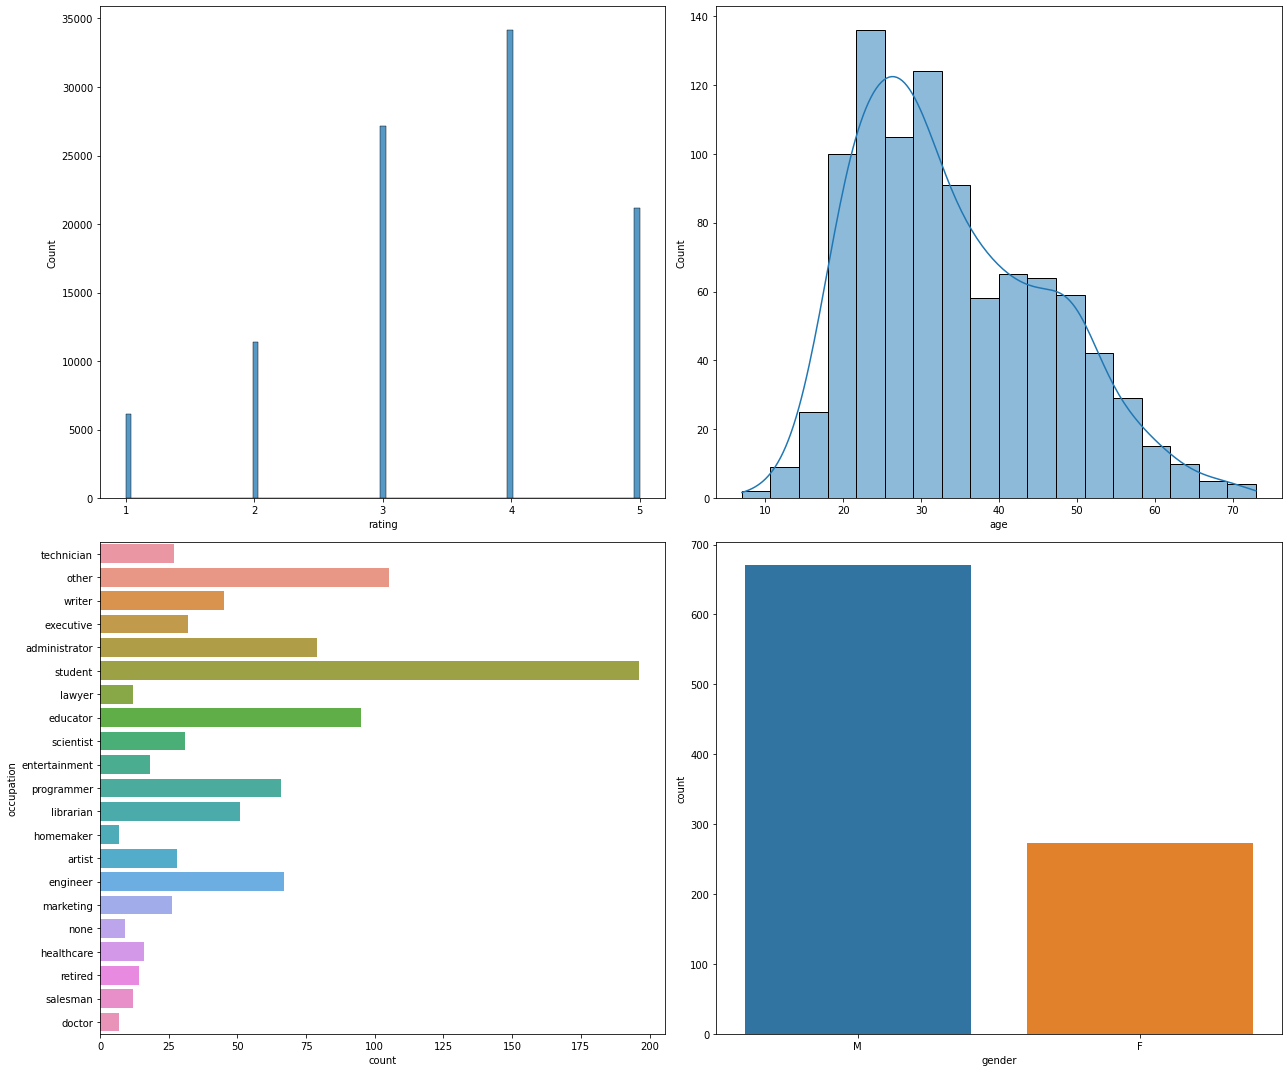

In [35]:
fig, axes = plt.subplots(2,2, figsize=(18,15))
sns.histplot(ratings['rating'],kde=False, ax=axes[0,0]).set_xticks([1,2,3,4,5])
sns.histplot(x=users['age'], kde=True, ax = axes[0,1])
sns.countplot(x=users['gender'], ax=axes[1,1])
sns.countplot(y=users['occupation'], ax=axes[1,0])



plt.tight_layout()
plt.show()

### Users

### Movies

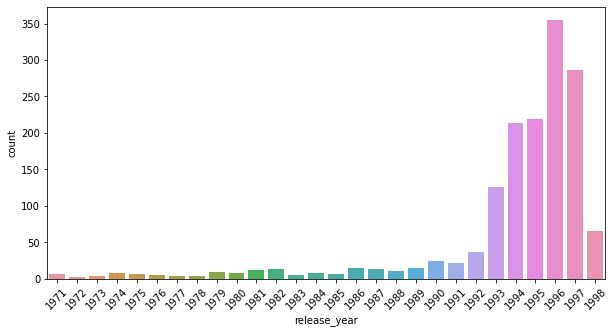

In [16]:
plt.figure(figsize=(10,5))
chart=sns.countplot(movies[movies['release_year']>1970]['release_year'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

### Reviews

In [17]:
ratings.rename(columns={'item_id':'movie_id'}, inplace=True)
ratings.head(2)

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742


In [18]:
movies.head(2)

,movie_id,movie_title,video_release_date,release_year,IMDB_URL,Action,Adventure,Animation,Children's,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,unknown
0,1,Toy Story (1995),1995-01-01,1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01,1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


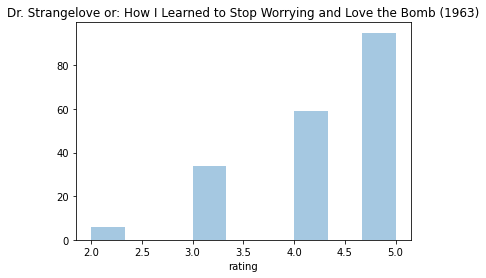

In [20]:
ratings_movies = ratings.join(movies.set_index('movie_id'), on=['movie_id'], how='left')
sns.distplot(ratings_movies[ratings_movies['movie_title']=='Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)']['rating'], kde=False)
plt.title('Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)')
plt.show()

## Experimentación

Durante todo este proyecto vamos a utilizar la librería `surprise` para llevar a cabo las experimentaciones.

Como se mencionó en clase, las implementaciones en esta librería tiene algunas mejoras respecto de las estrategias convencionales como SVD. Esto se traduce en una mayor cantidad de parámetros para optimizar.

Vamos a levantar los datos. En primer lugar, definamos el formato para poder leer los datos.

**1) Utilizar** el `Reader` con el parámetro `line_format` igual a `'user item rating timestamp'` y `sep` como `'\t'`. Guardarlo en una variable `reader`.

Utilizando este `reader` cargar los datos:

In [22]:
reader = Reader(line_format='user item rating timestamp', sep='\t')
data = Dataset.load_from_file('./dataset/ml-100k/u.data', reader=reader)

__2) Ejecutar una corrida inicial usando cross validation y el algoritmo SVD (5 folds). Imprimir los RMSE de testing.__

In [23]:
def run_cross_val(i:int = 100, verbose:bool = False):
    algo = SVD(n_factors=i)
    return cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=verbose, n_jobs=-1)
run_cross_val()

{'test_rmse': array([0.94218525, 0.9317853 , 0.93738232, 0.93838247, 0.93607953]),
 'fit_time': (8.718048095703125,
  9.385297298431396,
  9.007477760314941,
  9.199939012527466,
  5.62926983833313),
 'test_time': (0.4677600860595703,
  0.4768826961517334,
  0.5020613670349121,
  0.4704155921936035,
  0.1596851348876953)}

__3) Evaluar el RMSE (promedio de cross validation) de testing de acuerdo a la cantidad de factores en SVD.__

In [24]:
std=[]
rmse=[]
n_factors=[]

for i in range(10,101,10):
    n_factors.append(i)
    a = run_cross_val(i)
    rmse.append(np.mean(a['test_rmse']))
    std.append(np.std(a['test_rmse']))

__4) Graficar los promedios RMSE del conjunto de testing de acuerdo a la cantidad de factores en SVD.__

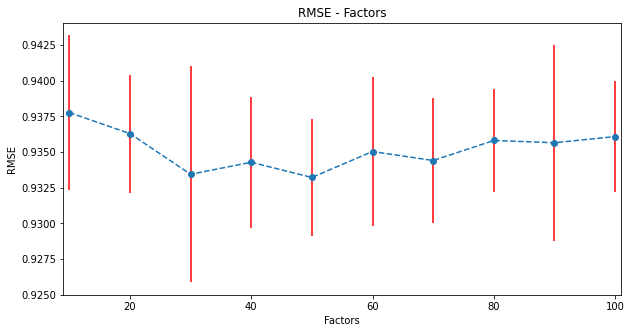

In [25]:
plt.figure(figsize=(10,5))

plt.errorbar(n_factors, rmse, yerr = std, fmt='--o', ecolor='r')
plt.title('RMSE - Factors')
plt.xlabel('Factors')
plt.ylabel('RMSE')
plt.xlim(9,101)
plt.show()

__5) Usando GridSearch, encontrar el mejor estimador usando SVD con 500 factores. Imprimir el mejor rmse. Utilizar `refit` para obtener obtener el mejor estimador ya ajustado como resultado.__

Utilizar el espacio de parámetros:
* n_epochs: [5, 10]
* lr_all: [0.002, 0.005]
* reg_all: [0.4, 0.6]


In [26]:
params = {
    'n_factors': [500],
    'n_epochs': [5, 10],
    'reg_all': [0.4, 0.6],
    'lr_all': [0.002, 0.005]
    }

In [ ]:
gs = GridSearchCV(SVD, params, measures=['RMSE'], cv=5, refit=True, n_jobs=-1)

In [27]:
gs.fit(data)

In [28]:
best_score = gs.best_score['rmse']
best_params = gs.best_params['rmse']

In [29]:
print(f'Best Parameters: {best_params}')

Best Parameters: {'n_factors': 500, 'n_epochs': 10, 'reg_all': 0.4, 'lr_all': 0.005}


In [30]:
print(f'Best Score: {best_score}')

Best Score: 0.9616418904904261


__6) Obtener una predicción para el usuario 321 para la película Titanic.__

In [31]:
algo = SVD(**best_params)
trainset = data.build_full_trainset()
algo.fit(trainset)

In [32]:
userid = 321
movie_name = "Titanic (1997)"

In [37]:
def toMovieID(movieTitle: str)->int:
    return list(movies[movies['movie_title']==movieTitle]['movie_id'])[0]

In [41]:
iid = toMovieID(movie_name)
print(f'Movie: {movie_name}\nID: {iid}')

Movie: Titanic (1997)
ID: 313


In [86]:
algo.predict(uid= str(321), iid=str(iid), r_ui = 4)

3.979433703190292

__7) Desarrollar una función que dado un usuario, obtenga la mejor predicción disponible (de acuerdo a nuestros datos de películas).__

In [164]:
def pred_user_preferences(user_id:str, verbose:bool= False):
    pred = {}
    best_pred = 0
    
    for movie_id in list(movies['movie_id']):
        movie_name = list(movies[movies['movie_id']==movie_id]['movie_title'])[0]
        
        pred_rating = float(tuple(algo.predict(user_id, str(movie_id), verbose=verbose, r_ui = 4))[3])
        
        if pred_rating > best_pred:
            pred[str(movie_name)] = pred_rating
            
            best_pred = pred_rating
    
    d_sorted_by_value = OrderedDict(sorted(pred.items(), key=lambda x: x[1], reverse=True))
    i = 0
    for k, v in d_sorted_by_value.items():
        if i == 0:
            print(f'The user might like:\n Movie Title: {k}\n Prediction: {v}\n')
            print('Other suggestions:')
        else:
            print(f' Movie Title: {k}\n Prediction: {v}\n')
        i+=1

In [165]:
pred_user_preferences('1345')

The user might like:
 Movie Title: Close Shave, A (1995)
 Prediction: 4.252661398495421

Other suggestions:
 Movie Title: Wrong Trousers, The (1993)
 Prediction: 4.226744459532503

 Movie Title: Shawshank Redemption, The (1994)
 Prediction: 4.194255233486169

 Movie Title: Usual Suspects, The (1995)
 Prediction: 4.154311583732023

 Movie Title: Babe (1995)
 Prediction: 3.8356588159659473

 Movie Title: Toy Story (1995)
 Prediction: 3.7785650515215856

